In [2]:
addpath('Functions')  
addpath('Revision1') 
addpath('Scripts')  

In [3]:
%%file Functions/newInfections_Total.m
function N = newInfections_Total(t,X,Gamma,nu,epsilon,Rt,Phi)
% obs X = [TSum HSum Hs];
T = X(1,:);
Ht = X(2,:);
if length(Phi)>1
    N = (nu+epsilon)*Gamma*Rt*T + Gamma*Rt*Ht + Phi;
else
    N = (nu+epsilon)*Gamma*Rt*T + Gamma*Rt*Ht + Phi;
end
N = N';

Created file '/Users/John/Documents/AustraliaStudy/Study/Research/covasim_delta/demo/compartmental model/Functions/newInfections_Total.m'.


In [4]:
%%file Functions/newInfections.m

function N = newInfections(t,X,Gamma,nu,Rt,lambda_s,lambda_r,nmax,eta)
% obs X = [TSum HSum Hs];
T = X(1,:);
Ht = X(2,:);
Hs = X(3,:);
nbt0 = eta*(lambda_s*Rt*Hs + lambda_r*Rt*Ht);
ne = zeros(size(T));
for i = 1:length(nbt0)
    ne(i) = min(nmax,nbt0(i));
end
N = nu*Gamma*Rt*T + lambda_s*Hs + lambda_r*Ht + ne;
N = N';

Created file '/Users/John/Documents/AustraliaStudy/Study/Research/covasim_delta/demo/compartmental model/Functions/newInfections.m'.


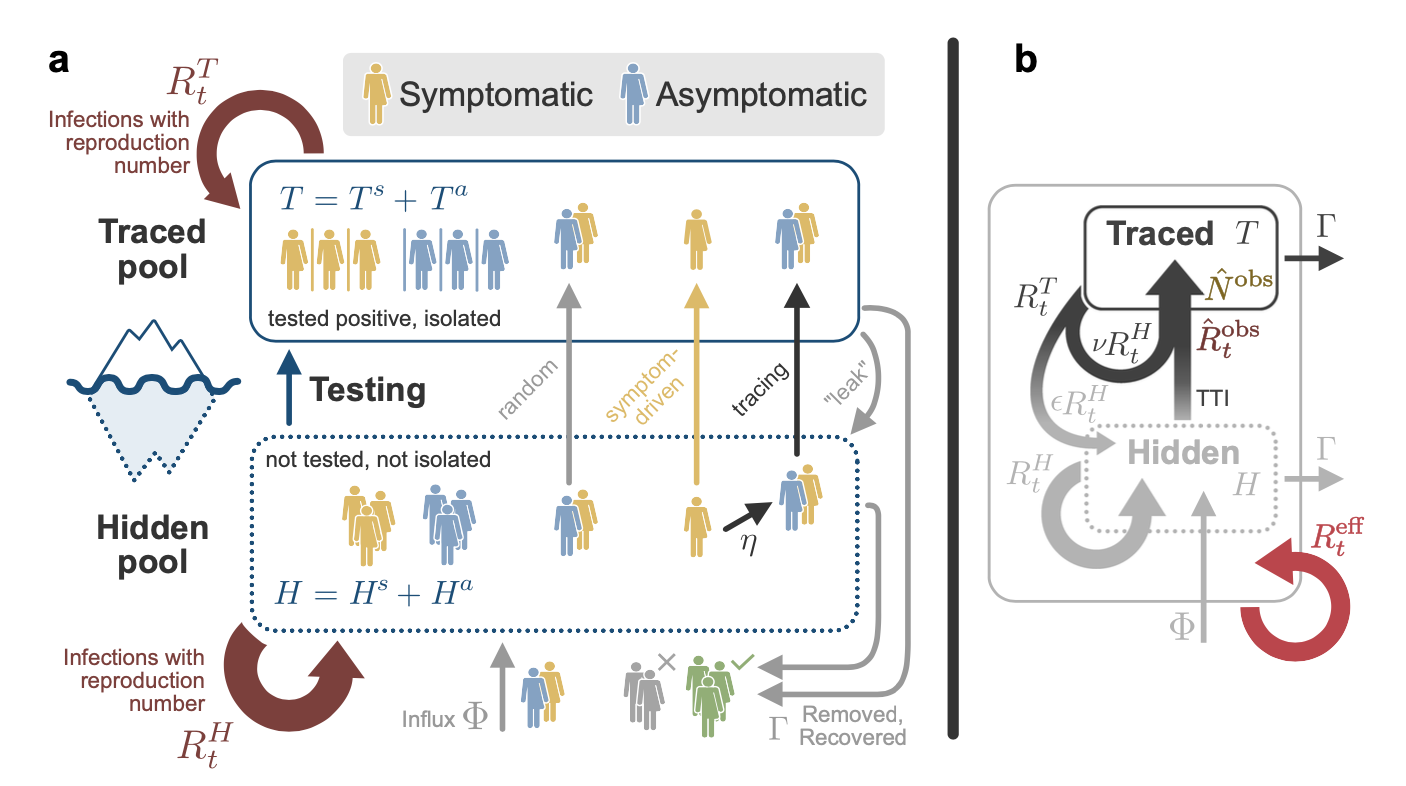

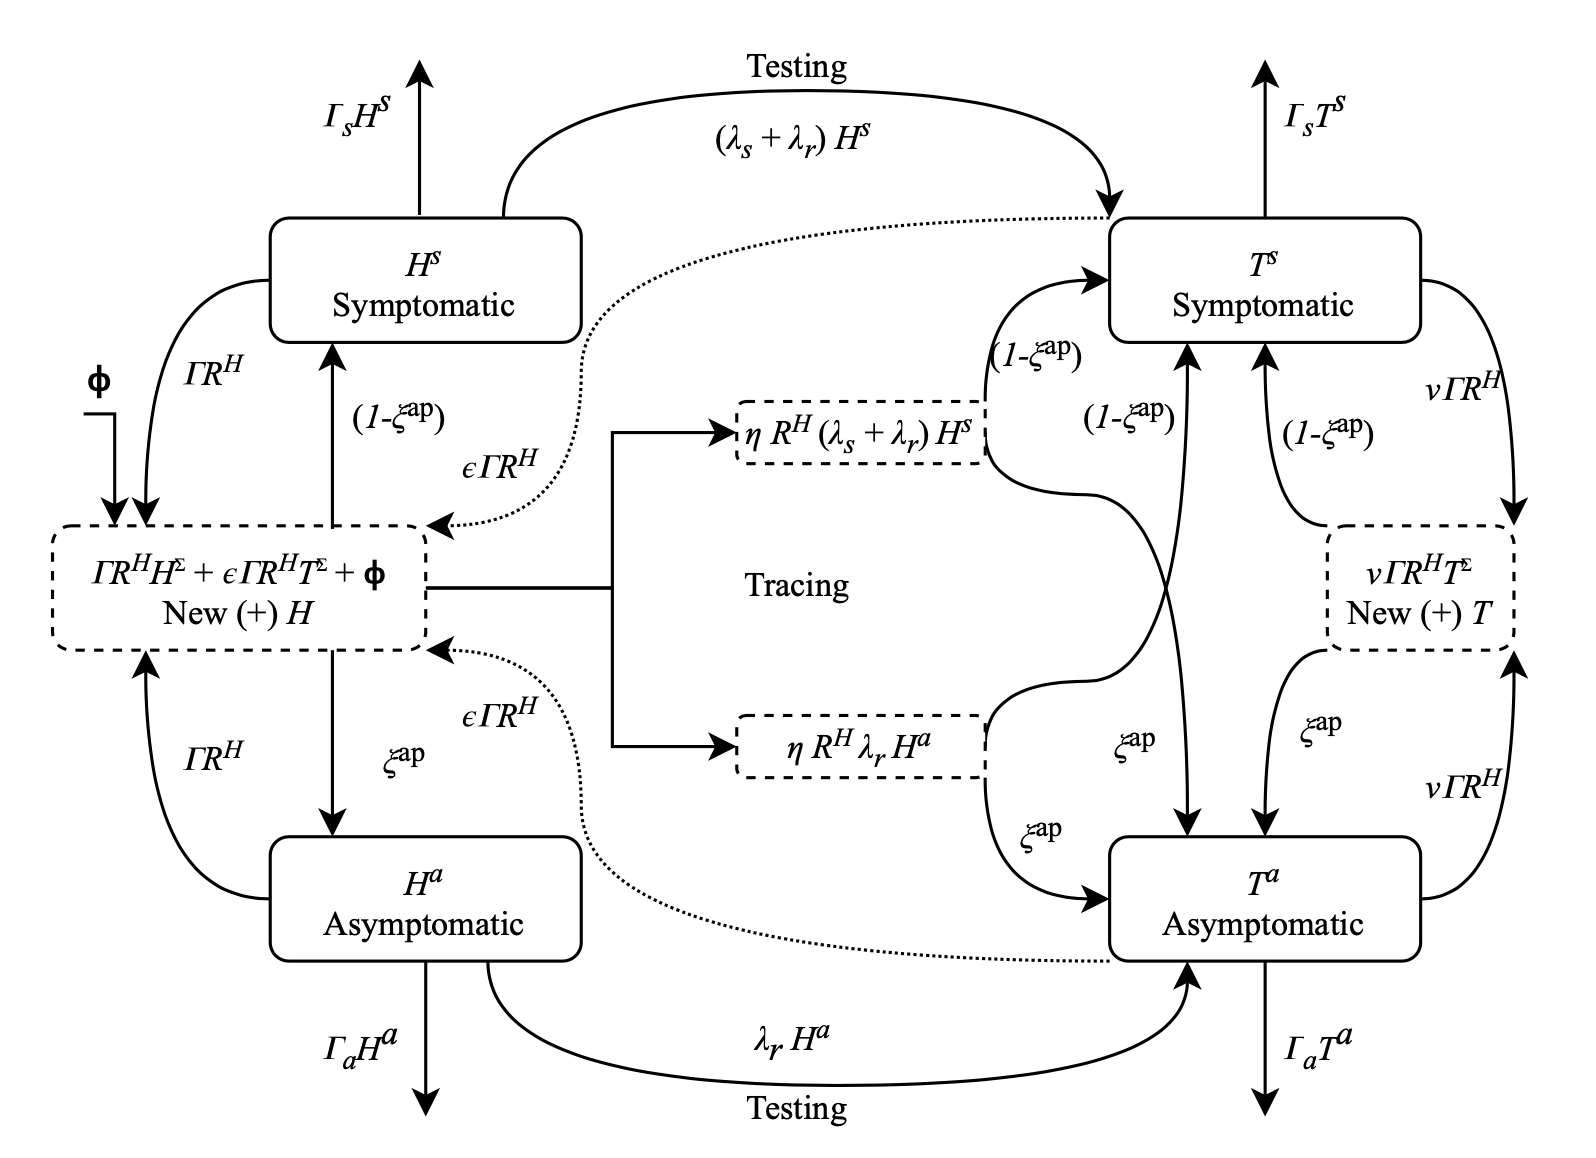

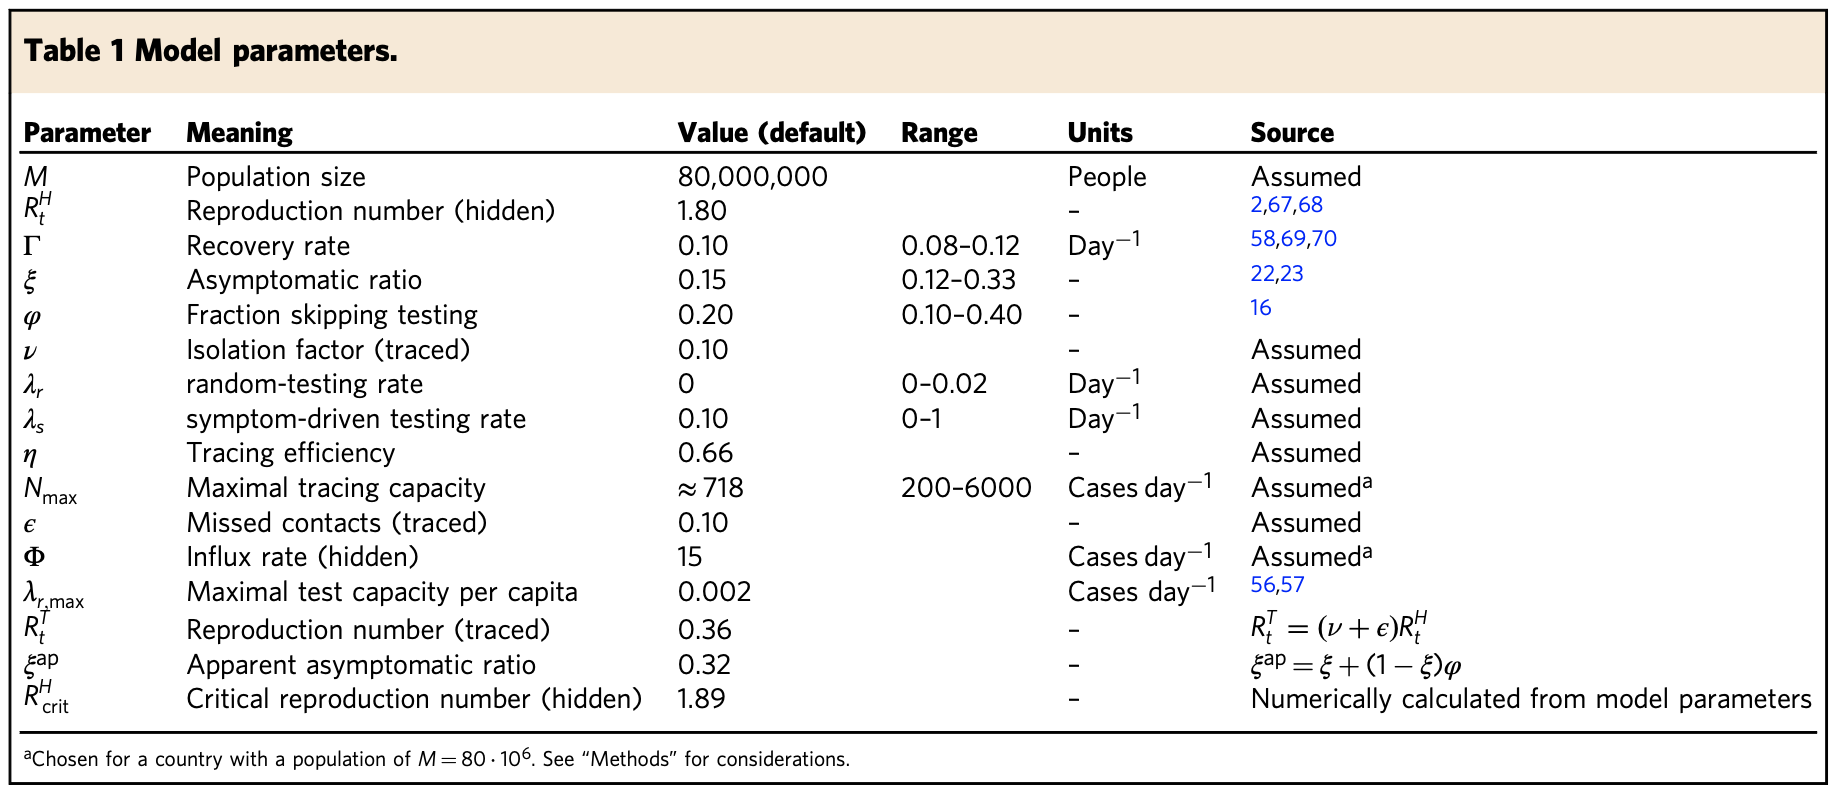

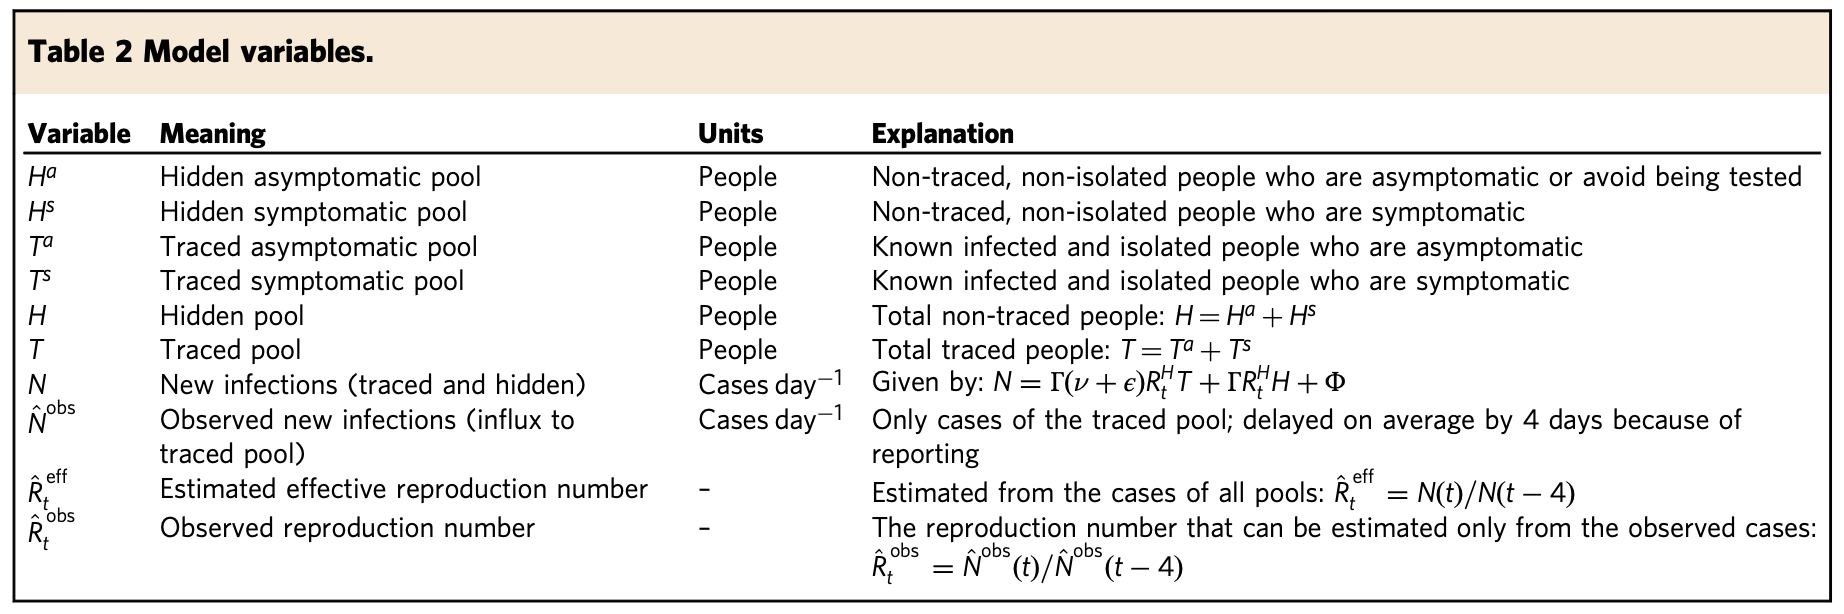

$\begin{align}
\cfrac{dT}{dt}&=\underbrace{\Gamma(\nu R_t^H -1)T}_{\text{spreading dynamics}} 
+\underbrace{\lambda_s H^s + \lambda_rH}_{\text{testing}}
+\underbrace{f(H^s,H)}_{\text{tracing}} \label{eq:vector_ray} \tag{1} \\
\cfrac{dH}{dt}&=\underbrace{\Gamma(R_t^H -1)H}_{\text{spreading dynamics}} 
-\underbrace{\lambda_s H^s + \lambda_rH}_{\text{testing}}
-\underbrace{f(H^s, H)}_{\text{tracing}}
+\underbrace{\Gamma\epsilon R_t^HT}_{\text{missed contacts}}
+\underbrace{\Phi}_{\text{external influx}}  \tag{2} \\
\cfrac{1}{1-\xi^{\text{ap}}}\cfrac{dH^s}{dt}&=
\underbrace{\Gamma(R_t^H H - \cfrac{H^s}{1-\xi^{\text{ap}}})}_{\text{spreading dynamics}} 
-\underbrace{\cfrac{(\lambda_s+\lambda_r)H^s}{1-\xi^{\text{ap}}}}_{\text{testing}}
-\underbrace{f(H^s, H)}_{\text{tracing}}
+\underbrace{\Gamma\epsilon R_t^HT}_{\text{missed contacts}}
+\underbrace{\Phi}_{\text{external influx}} \tag{3}\\
H^a &= H - H^s \tag{4}\\
f(H^s, H) &= \min\{n_\max, \eta R_t^H(\lambda_s H^s + \lambda_r H)\} \tag{5}\\
N(t) &= \underbrace{\Gamma(\nu + \epsilon) R_t^H T(t)}_{\text{traced pool}}
+ \underbrace{\Gamma R_t^H H(t)}_{\text{hidden pool}} + 
\underbrace{\Phi}_{\text{external influx}} \tag{6}\\ 
\hat{N}^\text{obs}(t) &= \left[
\underbrace{\Gamma\nu R_t^H T(t)}_{\text{traced pool}}
+ \underbrace{\lambda_s H^s(t) + \lambda_r H(t)}_{\text{testing}} + 
\underbrace{f(H^s(t), H(t))}_{\text{tracing}}
\right]
\mathcal{G}[\alpha=4, \beta=1](t) \tag{7}\\
\hat{R}_t^{\text{obs}} &=\cfrac{\hat{N}^\text{obs}(t)}{\hat{N}^\text{obs}(t-4)} \tag{8}\\
\hat{R}_t^{\text{eff}} &=\cfrac{N(t)}{N(t-4)} \tag{9} \\
\end{align}$

In [5]:
%%file Functions/Pools_solver.m

function F = Pools_solver(t,x,xi,nu,Rt,Gamma,lambda_s,lambda_r,eta,epsilon,nmax,Phi)
%                       (t,x,xi,rt,Gamma,nu,epsilon,lambda_s,lambda_r,eta,Phi,neff,1)
% 1->T^sum; 2->H^sum; 3->H^s
F = zeros(3,1);                       
xim = 1-xi;
nbt0 = eta*(lambda_r*Rt*x(2) + lambda_s*Rt*x(3));
if nbt0 >=nmax
    ne = nmax;
else
    ne = nbt0;
end
F(1) = Gamma*(nu*Rt-1)*x(1)         + lambda_r*x(2)                 + lambda_s*x(3)         + ne;
F(2) = Gamma*epsilon*Rt*x(1)        + (Gamma*(Rt-1)-lambda_r)*x(2)	- lambda_s*x(3)         - ne + Phi;
F(3) = xim*Gamma*epsilon*Rt*x(1)    + xim*Gamma*Rt*x(2)             -(lambda_s+lambda_r+Gamma)*x(3)  + xim*(Phi-ne);

Created file '/Users/John/Documents/AustraliaStudy/Study/Research/covasim_delta/demo/compartmental model/Functions/Pools_solver.m'.


In [6]:
%%file Functions/solver_por_tramos.m

function x = solver_por_tramos(ti,tf,dt,xi,nu,Rt,Gamma,lambda_s,lambda_r,eta,epsilon,nmax,Phi,x0)

t = ti:dt:tf;
[~,x] = ode45(@(t,x) Pools_solver(t,x,xi,nu,Rt,Gamma,lambda_s,lambda_r,eta,epsilon,nmax,Phi),t,x0);
x = x';

Created file '/Users/John/Documents/AustraliaStudy/Study/Research/covasim_delta/demo/compartmental model/Functions/solver_por_tramos.m'.


In [7]:
%%% Figure 2 %%%

clear all
close all
clc

%% Timeframe and initial conditions

ti = [-40 0];
tf = [0 120];
tmax = tf(end);
tmin = -20;
x0 = [0 20 0];
dt = 0.005;

%% Parameters 

% Default 
xi= 0.15; 
varphi = 0.2;
eta_sc = 0.66;
lambda_s = [0 0.1];
Rt = 1.8;
Rtlim = 2;
eta = [0 eta_sc];
xi = xi + (1-xi)*varphi; xim = 1-xi;
Gamma = 0.1;
nu = 0.1;
epsilon = 0.1;
lambda_r = 0;
Phi = 15;
rt = [Rt Rt];
nmax = 1e9;                     % Limitless tracing
kmax = length(ti);


%% Definici?n par?metros barrido


str = cell(1,kmax);
t = ti(1):dt:tf(end);
Xs = cell(kmax,1);
R0s = cell(kmax,1);
Nhat = cell(kmax,1);
Nhatobs = cell(kmax,1);

N_hat = [];
N_sum = [];
X = [];


 added to session magics.



In [8]:
for j = 1:length(ti)
    if j>1
        x0 = X(:,end)'; X(:,end)=[];
    end
    x = solver_por_tramos(ti(j),tf(j),dt,xi,nu,rt(j),Gamma,lambda_s(j),lambda_r,eta(j),epsilon,nmax,Phi,x0);
    if j>1
        N_hat = [N_hat(1:end-1) ; newInfections(ti(j):dt:tf(j),x,Gamma,nu,rt(j),lambda_s(j),lambda_r,nmax,eta(j))];
        N_sum = [N_sum(1:end-1) ; newInfections_Total(ti(j):dt:tf(j),x,Gamma,nu,epsilon,rt(j),Phi)];
    else
        N_hat = newInfections(ti(j):dt:tf(j),x,Gamma,nu,rt(j),lambda_s(j),lambda_r,nmax,eta(j));
        N_sum = newInfections_Total(ti(j):dt:tf(j),x,Gamma,nu,epsilon,rt(j),Phi);
    end
    X = [X x];
end
x = X;    

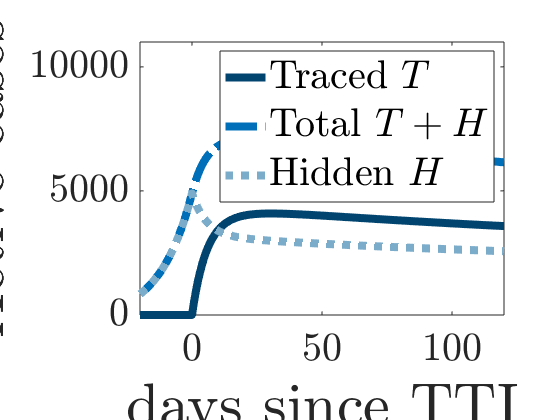

In [9]:
%% Discretizacion

idx = t==floor(t);
T = t(idx);
N_hat = N_hat(idx);
N_sum = N_sum(idx);

%% Calculo de los casos nuevos por d?a

N_hat_obs = EstimDelay(N_hat,4,1,0.95);
tau = 4;
Rt_hat_obs = N_hat_obs./[NaN(tau,1) ; N_hat_obs(1:end-tau)];
tau = 4;
N_T = EstimDelay(N_sum,4,1,0.95);
Rt_hat = N_T./[NaN(tau,1) ; N_T(1:end-tau)];

%% Visualization

load('Colores.mat')
lt = '-';
ls = '-.';
lh = ':';

fact_axis = 2;
fact_label = 3;
fact_curva = 2;
siz = 15;
green = [0 1 0]; 
blue = [0 0 1];

ylimsupI = 11000;
ylimsupN = 1200;
loc = 'northeast';
%% Fig a

figure('units','normalized','position',[0.3 0.3 0.5 0.6]);
ax = subplot(1,1,1);
ax.Position = [0.25 0.25 0.65 0.65];
ax.ActivePositionProperty = 'position';

plot(t,x(1,:),lt,'Color',bl1,'LineWidth',3*fact_curva)
hold on
plot(t,x(1,:) + x(2,:),ls,'Color',bl2,'LineWidth',3*fact_curva)
hold on
plot(t,x(2,:),lh,'Color',bl3,'LineWidth',3*fact_curva)
hold on
legend({'Traced $T$','Total $T+H$','Hidden $H$'},'interpreter','latex','FontSize',15*fact_axis,'Location',loc);
set(gca,'FontSize',15*fact_axis)
hold on
xlabel('days since TTI','interpreter','latex','FontSize',15*fact_label)
ylabel('Active cases','interpreter','latex','FontSize',15*fact_label)
ax.TickLabelInterpreter='latex';
xlim([tmin tmax])
ylim([0 ylimsupI])
hold on


In [ ]:

% %% Fig b

% figure('units','normalized','position',[0.3 0.3 0.5 0.6]);
% ax = subplot(1,1,1);
% ax.Position = [0.25 0.25 0.65 0.65];
% ax.ActivePositionProperty = 'position';

% plot(T,N_hat_obs,lt,'Color',or1,'LineWidth',3*fact_curva)
% hold on
% plot(T,N_sum,ls,'Color',or2,'LineWidth',3*fact_curva)
% hold on
% legend({'$\hat{N}^{\mbox{obs}}$','$N$'},'interpreter','latex','FontSize',15*fact_axis);
% set(gca,'FontSize',15*fact_axis)
% hold on
% xlabel('days since TTI','interpreter','latex','FontSize',15*fact_label)
% ylabel('New infections','interpreter','latex','FontSize',15*fact_label)
% hold on
% xlim([tmin tmax])
% ylim([0 ylimsupN])
% ax.TickLabelInterpreter='latex';


% %% Subfig c

% figure('units','normalized','position',[0.3 0.3 0.5 0.6]);
% ax = subplot(1,1,1);
% ax.Position = [0.25 0.25 0.65 0.65];
% ax.ActivePositionProperty = 'position';


% plot(T,Rt_hat_obs,lt,'Color',red1,'LineWidth',3*fact_curva)
% hold on
% plot(T,Rt_hat,ls,'Color',red2,'LineWidth',3*fact_curva)
% hold on
% plot(tmin:1:tmax,ones(size(tmin:1:tmax)),'k--','LineWidth',1*fact_curva,'HandleVisibility','off');
% hold on
% legend({'$\hat{R}_t^{\mbox{obs}}$','$\hat{R}_t$'},'interpreter','latex','FontSize',15*fact_axis);
% set(gca,'FontSize',15*fact_axis)
% hold on
% xlabel('days since TTI','interpreter','latex','FontSize',15*fact_label)
% ylabel('Rep. number','interpreter','latex','FontSize',15*fact_label)
% hold on
% ylim([0.75 Rtlim])
% xlim([tmin tmax])

% ax.TickLabelInterpreter='latex';